## Basic overview of ekpy functionality

We will be exploring the data in `./example_data/dataset1/` and `./example_data/dataset2/`

Each file will consist of data (x, y) which is a noisy gaussian distribution, *i.e.,* 

$y = \frac{1}{\sigma \sqrt{2\pi}}e^{\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$

at various simulated temperatures (T). 

- Temperature, T is the meta data of each file. 
- The data is fabricated such that $\mu \propto T$ and $\sigma \propto \sqrt{T}$. 

In [3]:
from ekpy import analysis

In [4]:
# load the dataset
dset = analysis.load_Dataset('./example_data/dataset1/')

# print dset, parsable collection of meta data which holds pointers to the real data files
dset

,Temperature,trial,filename
0,100,0,100K_0.csv
1,125,0,125K_0.csv
2,150,0,150K_0.csv
3,175,0,175K_0.csv
4,200,0,200K_0.csv
5,225,0,225K_0.csv
6,250,0,250K_0.csv
7,275,0,275K_0.csv
8,300,0,300K_0.csv
9,50,0,50K_0.csv


In [5]:
# using .query to select specific data based on meta data
dset.query('Temperature == 50')

,Temperature,trial,filename
0,50,0,50K_0.csv


(<Figure size 640x480 with 1 Axes>, <Axes: >)

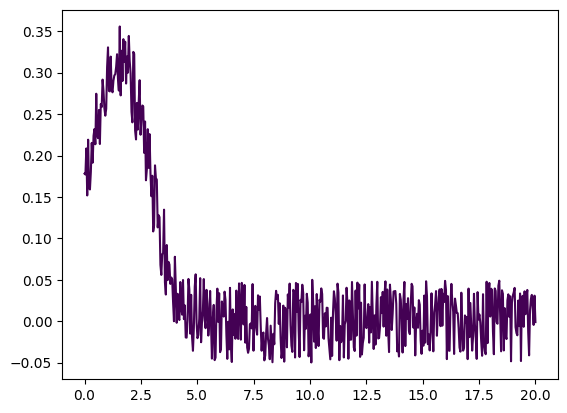

In [6]:
# plotting real data (i.e., x vs y) corresponding to specific meta data
dset.query('Temperature == 50').get_data().plot(x='x')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

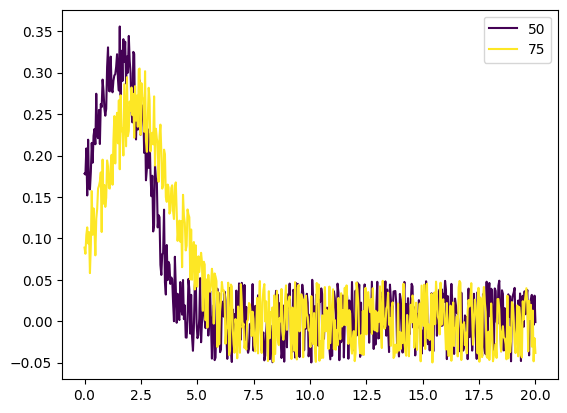

In [7]:
# query for multiple meta data values
dset.query('Temperature == 50 or Temperature == 75').get_data().plot(x='x', labelby='Temperature')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

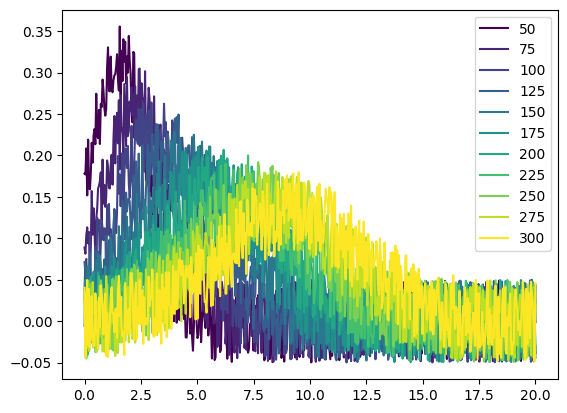

In [8]:
# remove .query to return all data in the data set
# sorting by meta data (definition) variable 'Temperature' and plotting as a colormap
dset.get_data().sort('Temperature').plot(x='x', labelby='Temperature')

In [9]:
# joining multiple datasets (file locations) into one, easy to use dataset
dset1 = analysis.load_Dataset('./example_data/dataset1/')
dset2 = analysis.load_Dataset('./example_data/dataset2/')
dset = analysis.concat_Datasets((dset1, dset2))

(<Figure size 640x480 with 1 Axes>, <Axes: >)

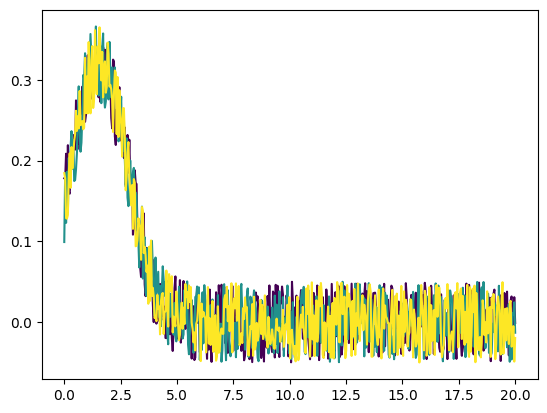

In [10]:
# now there are three files that correspond to a temperature of 50, 1 from dset1 and 2 from dset2
dset.query('Temperature == 50').get_data().plot(x='x')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

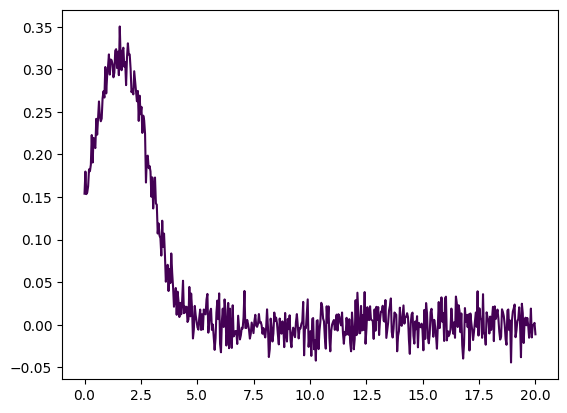

In [11]:
# group by like meta data and take the mean across trials
dset.query('Temperature == 50').get_data(groupby='Temperature').mean().plot(x='x')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

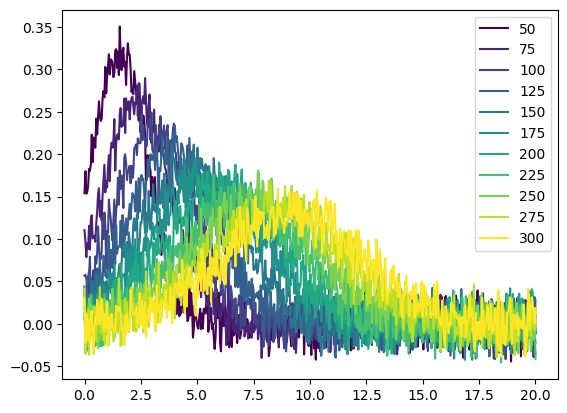

In [12]:
# group all data by meta data variable and average across trials. 
dset.get_data(groupby='Temperature').sort(by='Temperature').mean().plot(x='x', labelby='Temperature')

# Operating on data with `data.apply()`

In [13]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# define a fitting function describing a gaussian distribution 
def _fit(x, mu, sigma):
    return ((1)/((np.sqrt(2*np.pi))*(sigma)))*(np.exp((-1/2)*((x-mu)/(sigma))**2))

In [14]:
# define a function that can be used in .apply to fit the data to _fit
def fit_to_gauss(data_dict,) -> 'dict':
    X, Y = data_dict['x'], data_dict['y']
    
    # fit to _fit using curve_fit
    popt, _ = curve_fit(_fit, X, Y)
    # return new dict of raw data (x,y), fit params (mu, sigma), and a simulated data for the fit (fity)
    return {'x':X, 'y':Y, 'mu':popt[0], 'sigma':popt[1], 'fity':_fit(X, *popt)}

<Axes: >

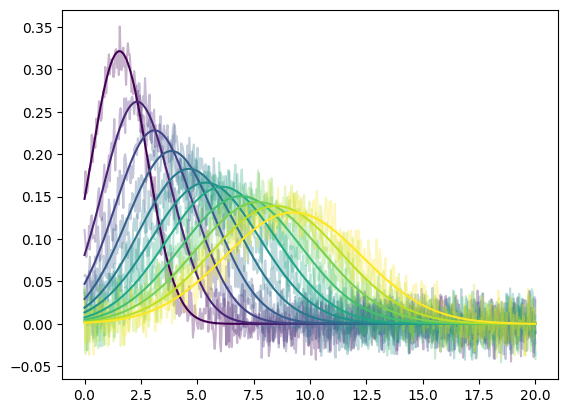

In [15]:
# group data by Temperature, average over trials
data = dset.get_data(groupby='Temperature').sort(by='Temperature').mean()

# fit each (now averaged) group to the gaussian distribution
fit_data = data.apply(fit_to_gauss)

# plot the averaged data 
fig, ax = data.plot(x='x', alpha=0.3)

# plot the fits on the same axis
fit_data.plot(x='x', y='fity', ax=ax)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\geofr\AppData\Local\Temp\ipykernel_10388\4174189112.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


Text(0, 0.5, '$\\mu$')

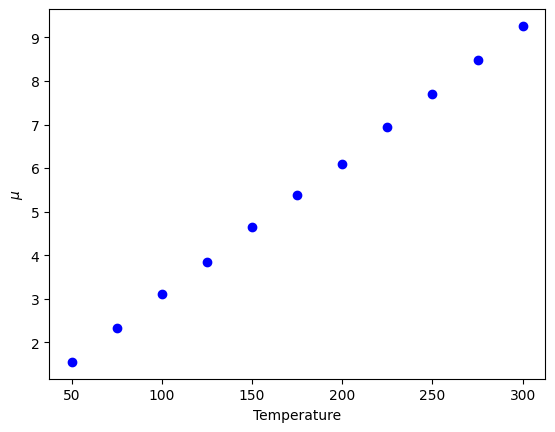

In [16]:
# get the mean (mu), a processed data value, of the fit distribution as a function of Temperature, a meta data value
vbd = analysis.get_vals_by_definition(fit_data, 'Temperature', 'mu')
X, Y = analysis.vals_by_definition_to_2darray(vbd)

plt.scatter(X, Y, color='blue')
plt.xlabel('Temperature')
plt.ylabel('$\mu$')

### We were able to recover the linear dependence of $\mu$, *i.e.,* the center of the gaussian distribution, on Temperature